In [1]:
import os
import pandas as pd
import torch
from torchvision import models, Module
from torchvision import transforms, datasets
from torch.utils.data import DataLoader,Dataset, random_split
from PIL import Image
from pathlib import Path
import pandas as pd, matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import timm

/home/faris/myvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder('/home/faris/LLMs/Dates dataset/train', transform=train_transforms)
test_dataset = datasets.ImageFolder('/home/faris/LLMs/Dates dataset/test', transform=val_transforms)

# Split train into train/val
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Apply validation transforms to validation split
val_dataset.dataset.transform = val_transforms

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

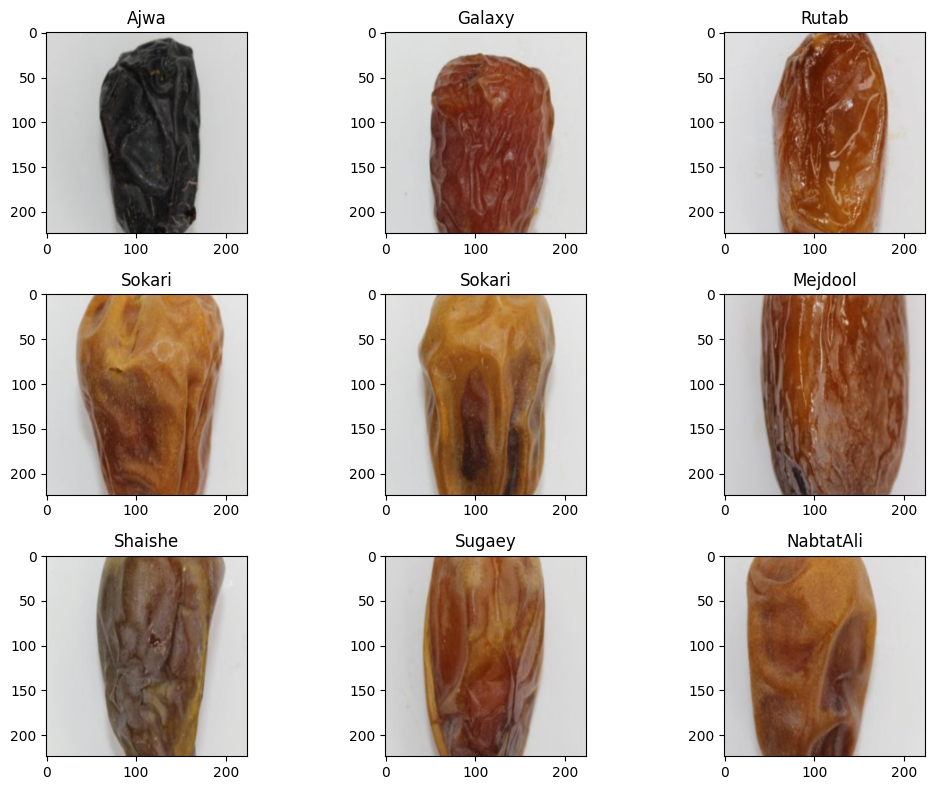

In [3]:
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(3, 3, figsize=(12,8))

axes = axes.ravel()

for i in range(min(9,len(images))):
    img = images[i]
    lab = labels[i]

    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)

    img = img.permute(1,2,0)

    axes[i].imshow(img)
    axes[i].set_title(train_dataset.dataset.classes[lab])

    plt.tight_layout()


In [4]:
def train(model, train_loader, criterion, optimizer, device):

        model.train()
        losses = 0.0
        correct = 0
        total = 0

        for img, lab in train_loader:
            img, lab = img.to(device), lab.to(device)
            outputs = model(img)
            loss = criterion(outputs, lab)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item() * img.size(0)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == lab).sum().item()
            total += lab.size(0)

        loss = losses / total 
        acc = correct / total
        print(f"Total Loss: {loss}")
        print(f"Accuracy: {acc}")
        
        return loss, acc

In [5]:
def eval(model, val_loader, criterion, device):
    model.eval()
    losses = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for img, lab in val_loader:
            img, lab = img.to(device), lab.to(device)
            outputs = model(img)
            loss = criterion(outputs, lab)
            losses += loss.item() * img.size(0)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == lab).sum().item()
            total += lab.size(0)
            
    loss = losses / total
    acc = correct / total
    print(f"Total Loss: {loss}")
    print(f"Accuracy: {acc}")

    return loss, acc

In [6]:
device = torch.device(
    'cuda:3' if torch.cuda.device_count() > 2 and torch.cuda.is_available()
    else ('cuda' if torch.cuda.is_available() else 'cpu')
)
model = models.alexnet(pretrained=True)

for param in model.features[:-2].parameters():  
            param.requires_grad = False
            
        
model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5/2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5/4),
            nn.Linear(256, 9)
        )

model = model.to(device) 


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01)

total_train_loss = []
total_val_loss = []
total_train_acc = []
total_val_acc = []


for epoch in range(15):

    print(f"Epoch {epoch+1}")

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = eval(model, val_loader, criterion, device)

    total_train_loss.append(train_loss)
    total_train_acc.append(train_acc)
    total_val_loss.append(val_loss)
    total_val_acc.append(val_acc)

/home/faris/myvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/faris/myvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1
Total Loss: 1.573095574007406
Accuracy: 0.5173160173160173
Total Loss: 0.9507959382287388
Accuracy: 0.8663793103448276
Epoch 2
Total Loss: 0.8396906318602624
Accuracy: 0.8744588744588745
Total Loss: 0.6357410509010841
Accuracy: 0.9439655172413793
Epoch 3
Total Loss: 0.6000665663640736
Accuracy: 0.9090909090909091
Total Loss: 0.4686766256546152
Accuracy: 0.9568965517241379
Epoch 4
Total Loss: 0.462279759573214
Accuracy: 0.9458874458874459
Total Loss: 0.3699691727243621
Accuracy: 0.9568965517241379
Epoch 5
Total Loss: 0.3598759318843032
Accuracy: 0.9621212121212122
Total Loss: 0.32359791829668244
Accuracy: 0.9612068965517241
Epoch 6
Total Loss: 0.3150918087659976
Accuracy: 0.9621212121212122
Total Loss: 0.28334884139998207
Accuracy: 0.9698275862068966
Epoch 7
Total Loss: 0.2707491185499992
Accuracy: 0.9642857142857143
Total Loss: 0.2692899539552886
Accuracy: 0.9525862068965517
Epoch 8
Total Loss: 0.22862396350541672
Accuracy: 0.9805194805194806
Total Loss: 0.24167248606681824
Acc

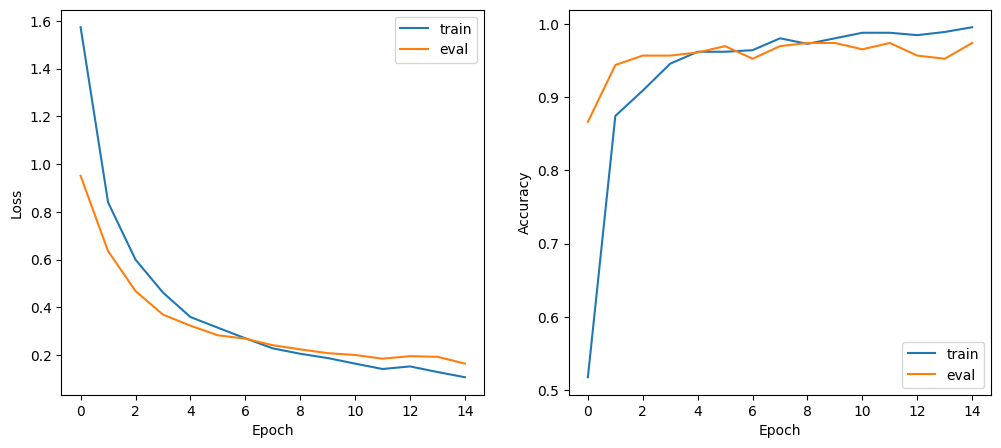

In [7]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

axes[0].plot(range(15),total_train_loss)
axes[0].plot(range(15),total_val_loss)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(['train','eval'])


axes[1].plot(range(15),total_train_acc)
axes[1].plot(range(15),total_val_acc)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend(['train','eval'])


In [10]:
correct = 0
total = 0.0
with torch.no_grad():
        for img, lab in test_loader:
            img, lab = img.to(device), lab.to(device)
            outputs = model(img)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == lab).sum().item()
            total += lab.size(0)
        print(f"The Test Accuracy: {correct/total}")

The Test Accuracy: 0.9641434262948207


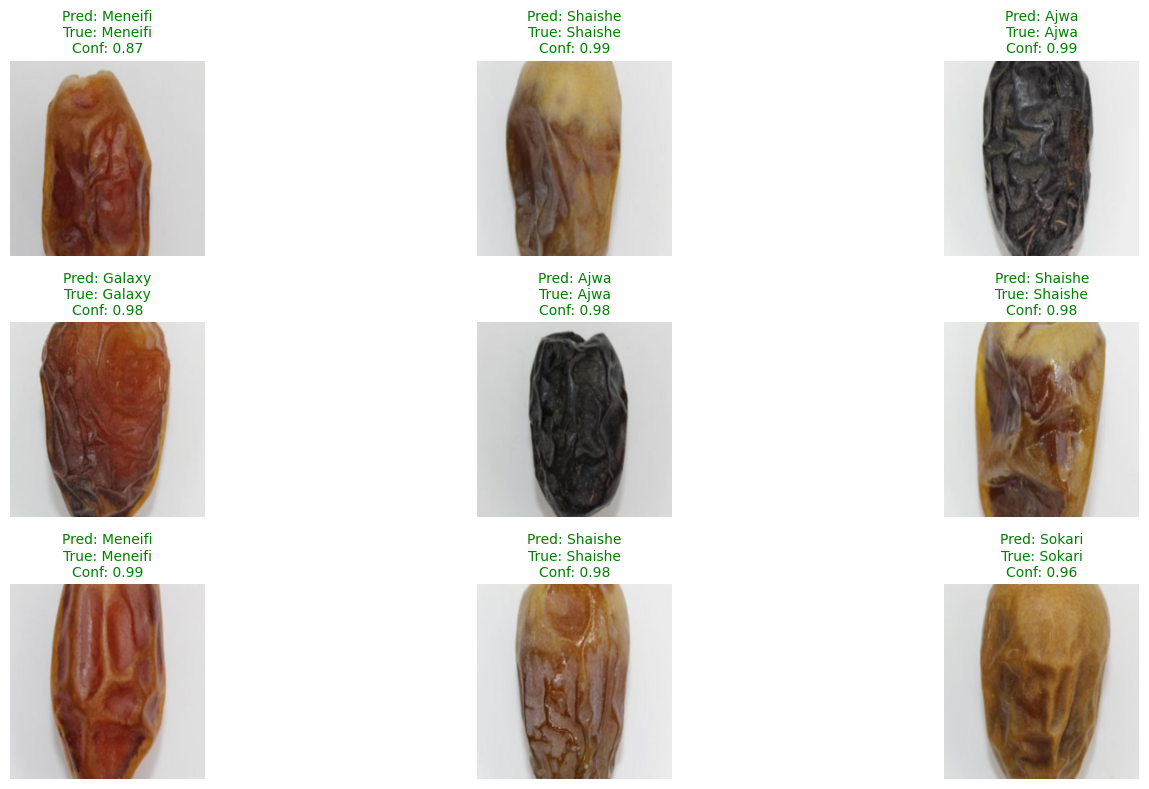

In [12]:

model.eval()
images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    outputs = model(images)
    probabilities = torch.softmax(outputs, dim=1)
    confidences, predicted = torch.max(probabilities, 1)

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
axes = axes.ravel()

class_names = test_dataset.classes

for i in range(min(9, len(images))):
    img = images[i].cpu()
    
    # Denormalize image
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1).permute(1, 2, 0)
    
    # Get prediction info
    pred_class = class_names[predicted[i].item()]
    true_class = class_names[labels[i].item()]
    confidence = confidences[i].item()
    correct = predicted[i].item() == labels[i].item()
    
    axes[i].imshow(img)
    
    color = 'green' if correct else 'red'
    axes[i].set_title(f'Pred: {pred_class}\nTrue: {true_class}\nConf: {confidence:.2f}', 
                     color=color, fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()
